<a href="https://colab.research.google.com/github/snel-repo/ComputationThruDynamicsBenchmark/blob/main/examples/WorkshopNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Background on tasks

The CtD Benchmark provides standarized code to:

1. **Train dynamics models to perform a specified task**
2. **Simulate neural activity from those task-trained models**
3. **Train dynamics models on simulated neural activity**
4. **Compare the inferred dynamics to the ground-truth dynamics from the task-trained model**

(From the authors) |The Computation-Thru-Dynamics Benchmark has three datasets simulated from models performing a distinct behavioral task.

These tasks are called:
1. Three-Bit Flip-Flop (3BFF)
2. MultiTask
3. RandomTargetReach

We chose these tasks because they represent a spectrum of complexities and the state of our previous understanding of their underlying computation.
 
The actions that the model takes in the "coupled" task can affect the future inputs, making it an important test case for being able to understand the dynamics of interacting systems.

<img src="png/TaskComplexity-01.png" width="600"/>

Each task (which we call a "task environment") follows a standardized format that allows alternative task environments to be incorporated without any changes to the task-training pipeline.

Here we'll take a walk through each task and inspect the behavior of task-trained networks on these environments.



In [1]:
# SET UP RUN DIRECTORIES
# !mkdir /content/ComputationThruDynamicsBenchmark/content
# !mkdir /content/ComputationThruDynamicsBenchmark/content/datasets
# !mkdir /content/ComputationThruDynamicsBenchmark/content/datasets/dt
# !mkdir /content/ComputationThruDynamicsBenchmark/content/datasets/sim
# !mkdir /content/ComputationThruDynamicsBenchmark/content/datasets/tt

# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
random.seed(2024)
dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)

/scratch/network/ad2002/


## Task 1: 3-Bit Flip-Flop

We're going to start out with the task that launched a thousand Nature papers, the 3-Bit Flip-Flop. [Sussillo & Barak 2013](https://pubmed.ncbi.nlm.nih.gov/23272922/) used the three-bit flip-flop their seminal attempts to understand how dynamics can give rise to computation! 

The code snippet below intantiates an "TaskEnv" object, which contains the logic for the NBFF task.

The default parameters are shown in ./interpretability/task_modeling/configs/env_task/NBFF.yaml, but try changing the parameters below to see how that affects trials generated from the environment. Note that this task is modular in the number of bits as well, so it provides an easy way to scale the dimensionality of a very simple dynamical system.

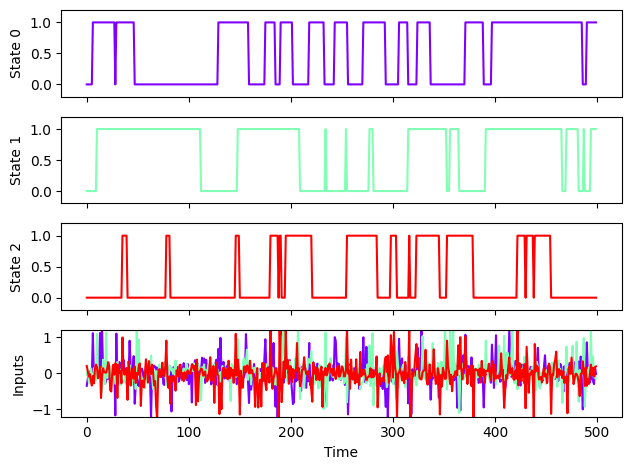

In [2]:
from ctd.task_modeling.task_env.task_env import NBitFlipFlop

n = 3
trial_length = 500
switch_prob = 0.05
noise = 0.2

env_3bff = NBitFlipFlop(
    n = n, 
    n_timesteps=trial_length, 
    switch_prob=switch_prob, 
    noise=noise
    )

env_3bff.render()

Above, we are plotting the inputs and outputs of the 3BFF task. One trial is 500 time steps, each with a 1% probability of getting an "up" or "down" pulse on each of its 3 input channels. When the task receives an "up" pulse, the state corresponding to that input channel moves from zero to one (if possible), and if a state at one receives a "down" pulse, it goes to zero. In this way, this system acts as 3 bits of memory, encoding 8 potential system states (2^3 states). We add noise to the inputs of the system so that it better reflects realistic computations that a neural circuit might perform.

Another way to visualize this is to view the three states in 3D. Below you can see that the 8 potential states appear as the vertices of a cube. Each trial is plotted as column. 

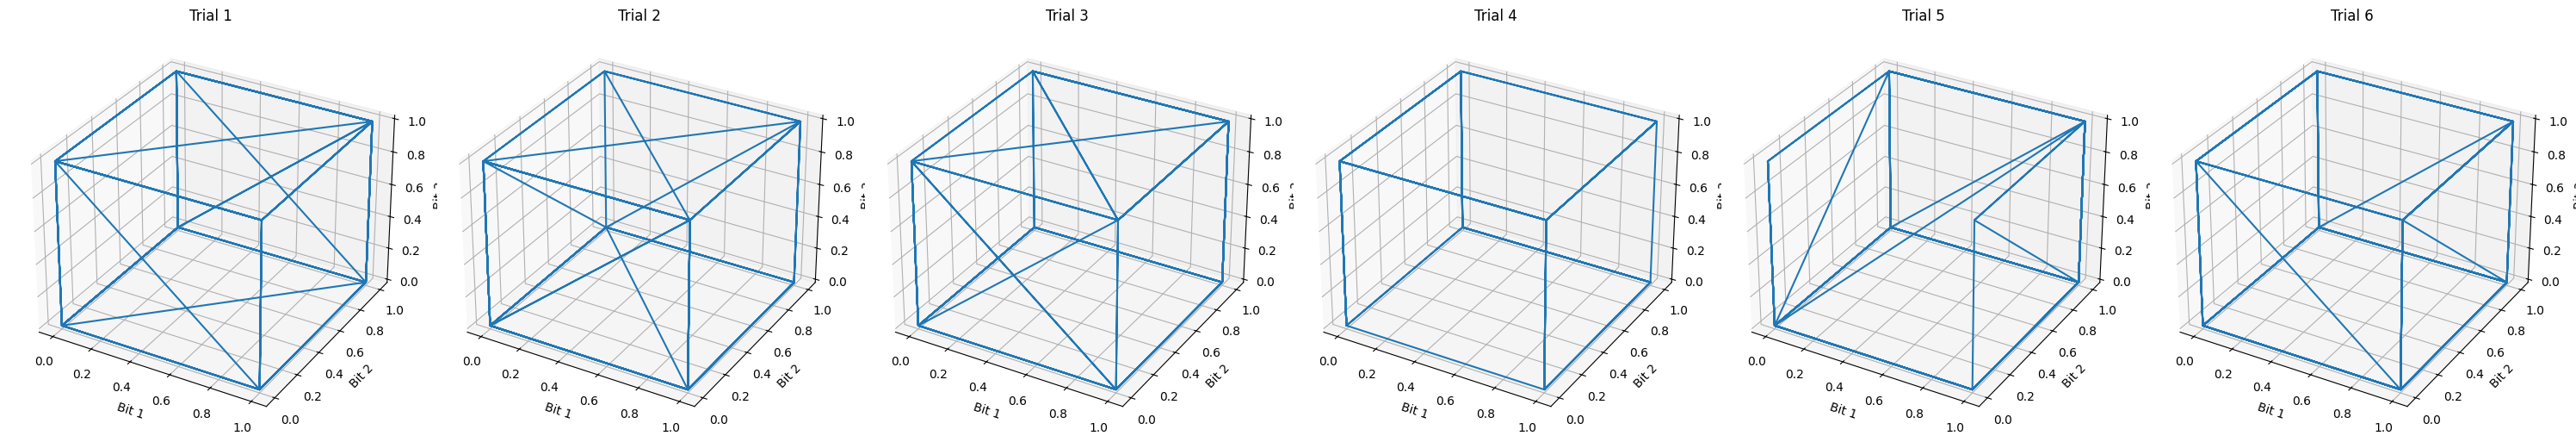

In [15]:
env_3bff.render_3d(n_trials=6)

Now that we can see the basic logic of the task, let's do a basic overview of what task-training is!

<img src="png/TTModelExample-01.png" width="600"/>

For task-training, we are simply training a model (e.g., an RNN) to produce a set of outputs given a set of inputs. This input/output relationship defines the task that the model is performing. In the case of 3BFF, an input pulse should cause the model's output to change in a way that reflects the switching of a bit.

### 3BFF Loss Function:
The 3BFF model was trained to minimize the MSE between the desired output and the output of the model, with the following qualification: The loss contributions of a given bit were zeroed in a short window after that bit received an input pulse. This reduces the stiffness of the learned dynamics and leads to simpler fixed-point structures.

For this tutorial, we are using the pre-trained models provided with the benchmark, but you can train your own models using ./examples/run_task_training.py

To inspect these models, we're going to use an Analysis object, which is a tool included in the benchmark that makes the models easier to work with. Initialize the Analysis with the folder where the saved model and datamodule live, and it will load them into a single object. 

Analysis objects provide tools for inspecting the features of the task-trained model, including useful functions for visualizing and interpreting the latent activity and dynamics.

### RESULTS 18/03/2024: latent activity vs targets

* Note that these first models were trained with a bug in the source code (missing generator instance in the task_wrapper class) that impedes their fixed point analysis.

* The default parameters left for the GRU RNN by the authors were used (only test for correctness)

**NODE RNN**

- Learning Rate: 1e-3
- Weight Decay: 1e-8
- Batch Size: 64
- random seed: 0
- Number of Epochs: 1500
- Number of workers: 4
- 8 cpus, 0.9 gpu (~4h total)

Cannot proceed in analysis due to bug, have to retrain

**IMPORTANT** model is clearly much more accurate when the number of epochs is 1500 instead of 150 (the test size)

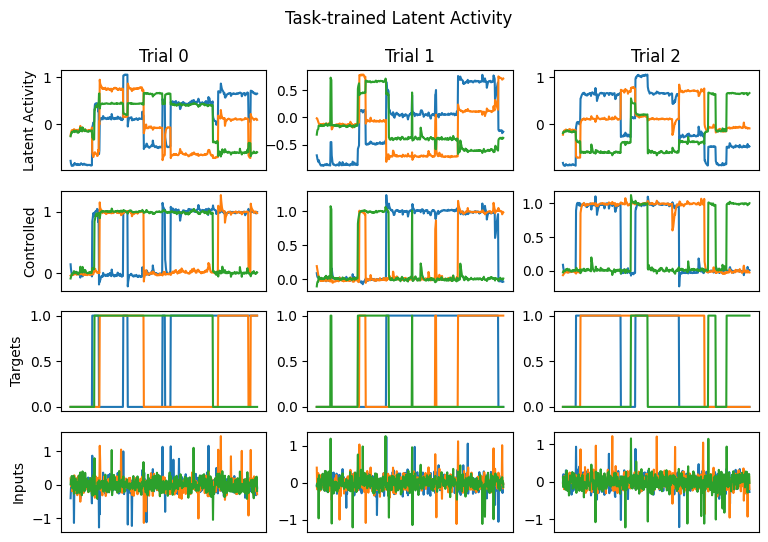

In [16]:
from ctd.comparison.analysis.tt.tt import Analysis_TT
fpath_3bff = "/scratch/network/ad2002/content/trained_models/task-trained/20240312_NODE_NBFF_Test/weight_decay=1e-08 max_epochs=1500 seed=0/"
# Create the analysis object:
analysis_tt_3bff = Analysis_TT(
    run_name = "tt_3BFF", 
    filepath = fpath_3bff)

analysis_tt_3bff.plot_trial_io(num_trials=5)

In [ ]:
# Plot train and test loss as a function of the epoch



In [ ]:
from ctd.comparison.analysis.tt.tt import Analysis_TT
fpath_3bff = "/scratch/network/ad2002/content/trained_models/task-trained/20240321_NODE_N3BFF_march21/weight_decay=1e-07 learning_rate=0.0001 max_epochs=1500 seed=0 batch_size=256 num_workers=4 n_samples=1000/"
# Create the analysis object:
analysis_tt_3bff = Analysis_TT(
    run_name = "tt_3BFF", 
    filepath = fpath_3bff)

analysis_tt_3bff.plot_trial_io(num_trials=5)

### Percent variance explained vs PCs

In how many dimensions does the latent activity lie?

In [5]:
analysis_tt_3bff.plot_scree()

# BUG: models were trained with a script with the wrong attribute. need to run again to access this function

ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=3 with svd_solver='full'

Finally, we can use fixed-point finding to inspect the linearized dynamics of the trained model.
Fixed points are points in the dynamics for which the flow field is zero, meaning that points at that location do not move.

We use a modified version of a fixed point finder released by [Golub et al. 2018](https://github.com/mattgolub/fixed-point-finder) to search the flow field for these zero points.

Try changing some of these parameters: 
- How quickly are the fixed-points found in the model?
- How many initializations are needed to find the fixed points?
- Do the stability properties tell us anything about the underlying computation?

Importantly from [Driscol et al. 2022](https://www.biorxiv.org/content/10.1101/2022.08.15.503870v1.full.pdf), we know that changes in the inputs can have large effects on the fixed point architecture, so we're going to set the inputs to zero in this optimization.

In [6]:
import torch
fps = analysis_tt_3bff.plot_fps(
inputs= torch.zeros(3),
n_inits=1024,
learning_rate=4e-3,
noise_scale=0.05,
max_iters=30000,
seed=0,
compute_jacobians=True,
q_thresh=1e-9,
)

AttributeError: 'NODE' object has no attribute 'cell'

Everything looks good! There are 8 fixed points on the vertices of the cube, and ~2 fixed points at the transition areas that mediate the transition of the state between bits.

Now, are there any predictions on what the system would look like while one of the inputs is on? In other words, how will the fixed points change?


Iteration 500/30000
q = 6.09E-03 +/- 1.26E-02
dq = 3.67E-05 +/- 8.18E-05

Iteration 1000/30000
q = 1.33E-03 +/- 2.55E-03
dq = 2.27E-06 +/- 6.51E-06

Iteration 1500/30000
q = 6.75E-04 +/- 1.21E-03
dq = 7.91E-07 +/- 2.44E-06

Iteration 2000/30000
q = 4.10E-04 +/- 7.17E-04
dq = 3.58E-07 +/- 6.74E-07

Iteration 2500/30000
q = 2.72E-04 +/- 4.92E-04
dq = 1.98E-07 +/- 3.04E-07

Iteration 3000/30000
q = 1.95E-04 +/- 3.73E-04
dq = 1.24E-07 +/- 2.70E-07

Iteration 3500/30000
q = 1.42E-04 +/- 2.17E-04
dq = 8.59E-08 +/- 2.85E-07

Iteration 4000/30000
q = 1.07E-04 +/- 1.33E-04
dq = 5.94E-08 +/- 1.53E-07

Iteration 4500/30000
q = 8.13E-05 +/- 8.41E-05
dq = 4.10E-08 +/- 6.57E-08

Iteration 5000/30000
q = 6.40E-05 +/- 6.38E-05
dq = 2.95E-08 +/- 3.57E-08

Iteration 5500/30000
q = 5.11E-05 +/- 4.92E-05
dq = 2.26E-08 +/- 2.73E-08

Iteration 6000/30000
q = 4.11E-05 +/- 3.78E-05
dq = 1.79E-08 +/- 2.24E-08

Iteration 6500/30000
q = 3.33E-05 +/- 2.94E-05
dq = 1.44E-08 +/- 1.60E-08

Iteration 7000/30000
q = 

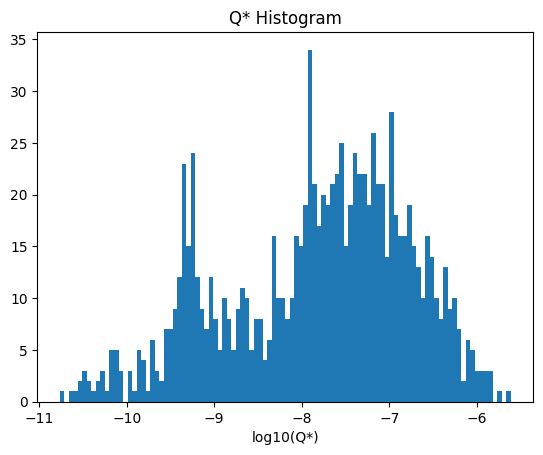

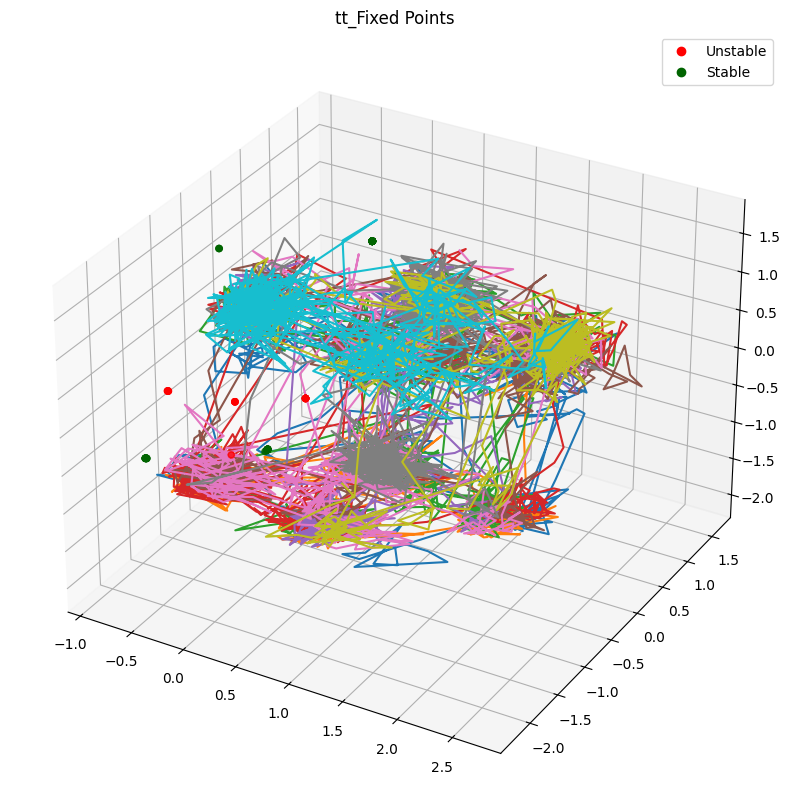

In [13]:
import torch
fps = analysis_tt_3bff.plot_fps(
inputs= torch.Tensor([1,0,0]),
n_inits=1024,
learning_rate=4e-3,
noise_scale=0.05,
max_iters=30000,
seed=0,
compute_jacobians=True,
q_thresh=1e-9,
)

What can we learn about the computational solution built in this TBFF network from these fixed-point architectures?

## Task 2: MultiTask:
The second task included in the benchmark is adapted from Laura Driscoll's network in [this paper](https://www.biorxiv.org/content/10.1101/2022.08.15.503870v1.full.pdf), based in turn on [this paper](https://www.nature.com/articles/s41593-018-0310-2) from Robert Yang.

This network is trained to perform 15 different tasks, some of which share computational features such as memory and a variable response direction. 

The dataset used to train the RNN has 2000 trials per task, but the simulated data only has 500 trials per task to make the trial counts more biologically plausible.

The loss function of this task minimizes the MSE between the output targets and the model outputs, weighted according to the trial phases. Additionally, losses immediately after the response signal are ignored. See /interpretability/task_modeling/task_env/loss_func.py for the full implementation details.

Importantly, the trial lengths can vary substantially between task types and trials, so your data-trained models need to be able to handle dissimilar trial lengths!

The particulars of all of these tasks are beyond the scope of this tutorial, so we'll just take two of the tasks as examples to demonstrate the basic features of this dataset

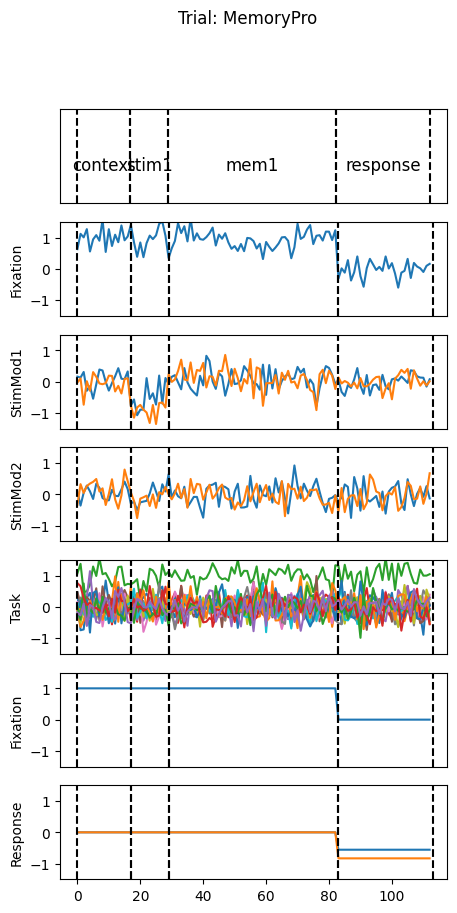

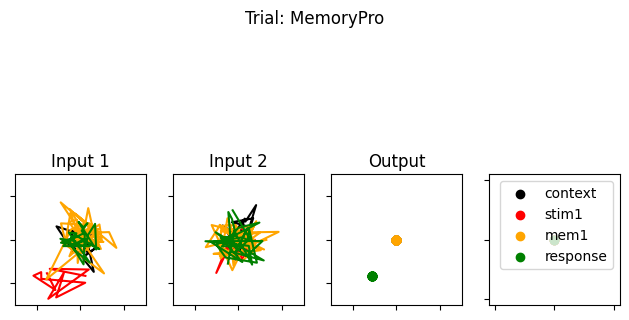

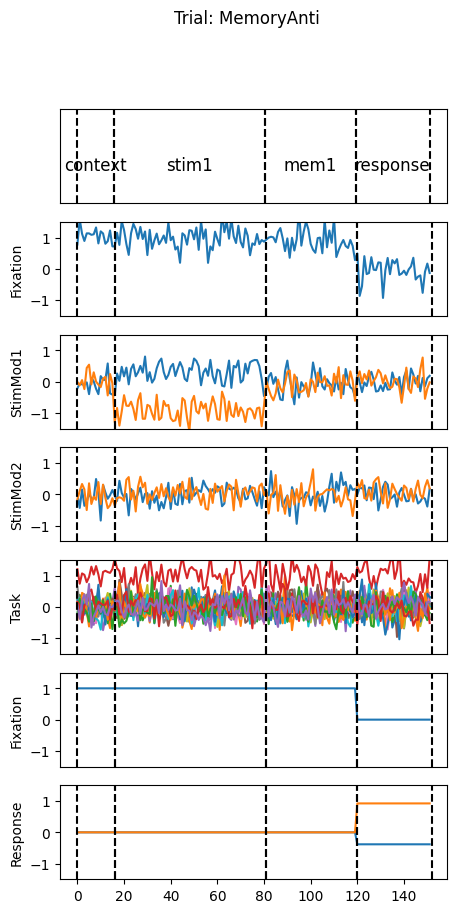

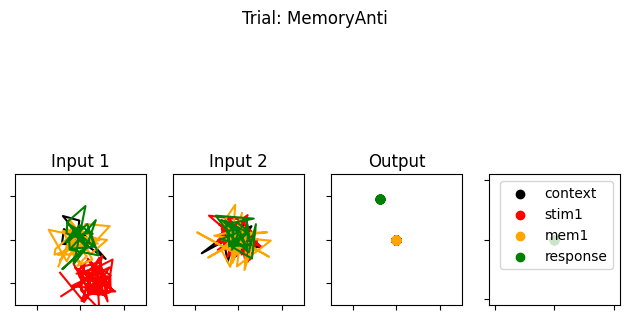

In [7]:
from ctd.task_modeling.task_env.multi_task_env import MultiTaskWrapper

multitask = MultiTaskWrapper(
    task_list = [
        "MemoryPro",
        "MemoryAnti",
    ],
    noise = 0.3,
    num_targets = 32,
    bin_size=20,
    n_timesteps= 640,
)

multitask.plot_tasks()


Looking at the plots, we can see that there are 4 phases to both MemoryPro and MemoryAnti:
1. context: In this phase, a one-hot encoding of the task (15 total task inputs) is fed to the model to indicate how the network is meant to process the inputs.
2. stim1: In this phase, a 2D input stimulus is fed into the Input 1 channels (x, y coordinates). Being memory tasks, both models are asked to remember this input.
3. mem1: In this phase the input stimulus returns to zero, and the model needs to remember what input it saw.
4. response: In this phase, the network responds. In the case of MemoryPro, it moves in the direction of the input stimulus. In the case of MemoryAnti, it moves in the opposite direction.

Now let's load up our pre-trained RNN that has learned to do MultiTask!

In [11]:
import dotenv
import pathlib
import os
# dotenv.load_dotenv(override=True)
# HOME_DIR = os.getenv("HOME_DIR")
# print(HOME_DIR)
from ctd.comparison.analysis.tt.tasks.tt_MultiTask import Analysis_TT_MultiTask
# Create the analysis object
fpath_multitask = "/scratch/network/ad2002/content/trained_models/task-trained/20240314_NODE_MultiTask_Test/weight_decay=1e-08 max_epochs=1500 seed=0/"
analysis_tt_multitask = Analysis_TT_MultiTask(
    run_name = "tt_MultiTask_NODE", 
    filepath = fpath_multitask)

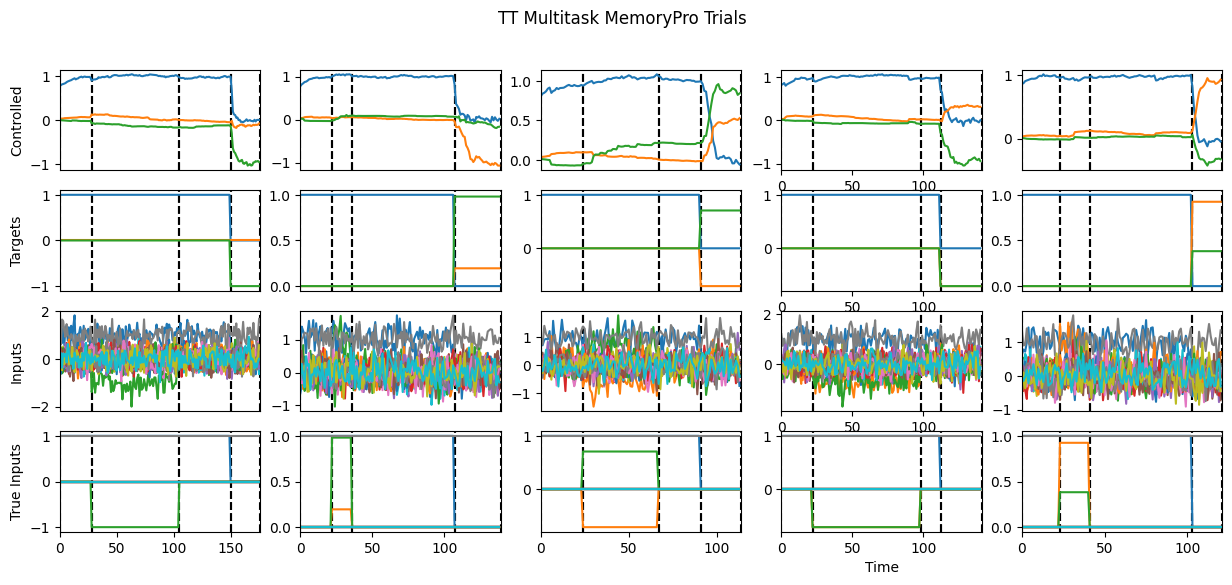

In [13]:
analysis_tt_multitask.plot_task_trial(task= "MemoryPro", num_trials=5)

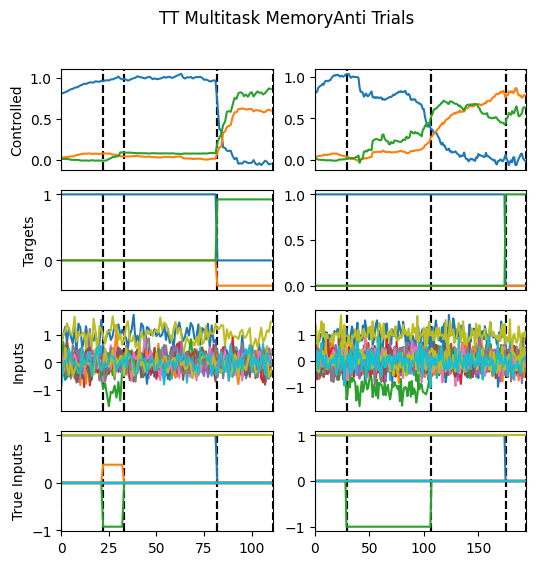

In [15]:
analysis_tt_multitask.plot_task_trial(task= "MemoryAnti", num_trials=2)

First, we can see that in the MemoryPro task, the model is reaching in the same direction as the inputs, while in the MemoryAnti it is reaching in the opposite direction.  

Second, we can see that our model seems to be performing both tasks pretty well (comparing Targets to Controlled).

Can we now use our FixedPoint finding to say anything about the underlying dynamics?

Importantly, fixed points are only meaningful in a regime where the inputs are stable, so let's pick the MemoryPro task and the memory phase for our FP analysis.

In [16]:
import torch
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

fps = {}
xstar_pca = []
fps_out = []
q_star = []
num_phases = 4
task_to_analyze = "MemoryPro"
phase_names = ['context', 'response']
phase_list = [['context', 'mem1'],'response']
pca = PCA(n_components=2)
readout = analysis_tt_multitask.wrapper.model.readout
# For each phase, compute the fixed points
for i, phase_for_fp in enumerate(phase_list):
    print(f"Computing fixed points for {phase_names[i]} using {phase_for_fp}")
    # Returns fps and x_trajs in the original space
    fps[phase_names[i]]= analysis_tt_multitask.compute_fps_phase(
        n_inits=512,
        phases=phase_for_fp, 
        task_to_analyze="MemoryPro", 
        noise_scale=0.01, lr = 1e-3, 
        max_iters = 10000, use_noisy = False
        )
    # Transform the fps and x_trajs into the PCA space
    xstar= fps[phase_names[i]].xstar
    xstar_pca.append(pca.fit_transform(xstar))
    fps_out.append(readout(torch.Tensor(xstar)).detach().numpy())
    q_star.append(fps[phase_names[i]].qstar)
xstar_pca = np.stack(xstar_pca, axis = 0)
fps_out = np.stack(fps_out, axis = 0)
fps_mat = np.concatenate((xstar_pca[:,:,:2], fps_out[:,:,1:2]), axis=2)
q_star = np.stack(q_star, axis = 0)
# Set values of qstar that are zero to 1e-16 for plotting
q_star[q_star == 0] = 1e-16
fig = plt.figure(figsize=(10*num_phases, 10))
for i, phase in enumerate(phase_names):
    # Add histogram of qstar
    ax = fig.add_subplot(1, num_phases, i+1)
    ax.hist(np.log10(q_star[i]), bins=50)
    ax.set_xlabel("qstar")
    ax.set_ylabel("Count")
    ax.set_title(f"qstar for {task_to_analyze} {phase}")
plt.show()


Computing fixed points for context using ['context', 'mem1']


AttributeError: 'NODE' object has no attribute 'cell'

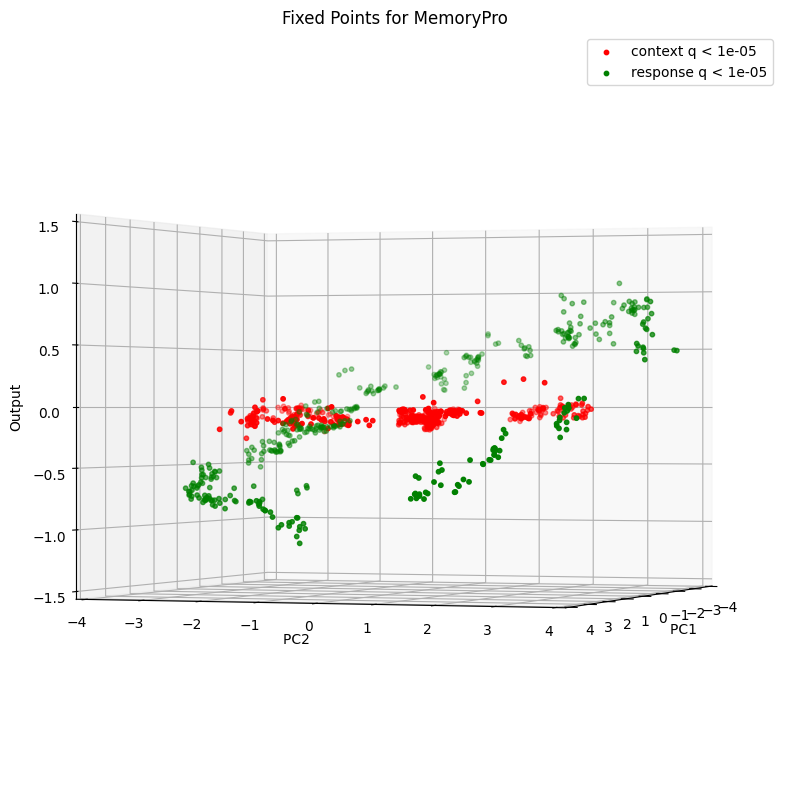

In [19]:
# window to only FPs whose q values are less than thresh
fps_plot = fps_mat.copy()
threshs = [1e-5, 1e-5]
colors = ['r', 'g']
for i, phase in enumerate(phase_names):
    q_flag = q_star[i] < threshs[i]
    fps_plot[i, ~q_flag, :] = np.nan

# combine lats_pca 1 and 2 and output 1
fig = plt.figure(figsize=(10*num_phases, 10))
ax = fig.add_subplot(1, 1, 1, projection="3d")
for i, phase in enumerate(phase_names):
    ax.scatter(
        fps_plot[i,:,0], 
        fps_plot[i,:,1], 
        fps_plot[i,:,2], 
        s=10, c=colors[i],
        label = f"{phase} q < {threshs[i]}"
        )
    ax.set_xlabel(f"PC1 ")
    ax.set_ylabel(f"PC2 ")
    ax.set_zlabel("Output")
    ax.set_title(f"Fixed Points for {task_to_analyze}")
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-1.5, 1.5])
    ax.legend()
    # Set view
    ax.view_init(0, 20)

As expected, we see that this model performs the task by placing a ring of fixed points that have zero projection onto the output decoder during the context and memory phases.

When the reponse phase begins, this ring rotates into the readout-potent space!

Overall, the multi-task dataset shows interesting dynamics with interpretable fixed-point structures (showin in the clip below) that our data-trained models will hopefully be able to reconstruct!

<img src="png/loopingMultiTask.gif" width="600"/>


## Task 3: Random Target:
The final task is a random-target reaching task performed by an RNN controlling a 2-joint musculoskeletal model of an arm actuated by 6 Mujoco muscles. This environment was built using MotorNet, a package developed by [Oli Codol et al.](https://github.com/OlivierCodol/MotorNet) that provides environments for training RNNs to control biomechanical models!

Here is a short clip of what this task looks like:

<img src="png/FinalGif.gif" width="300"/>


Behaviorally, the task has the following structure:
1. A random initial hand position is sampled from a range of reachable locations; the model is instructed to maintain that hand position.
2. A random target position is chosen from the range of reachable locations and fed to the model.
3. After a random delay period, a go-cue is fed to the model, which prompts the model to generate muscle activations that drive the hand to the target location.
4. On 20% of trials, the go-cue is never supplied ("catch" trials)
5. On 50% of trials, a randomly directed bump perturbation (5-10 N, 150-300 ms duration) is applied to the hand.
    - 50% of these bumps occur in a small window after the go-cue
    - 50% of these bumps occur at a random time in the trial

The model is trained to:
1. Minimize the MSE between the hand position and the desired hand position
2. Minimize the squared muscle activation

with each loss term being weighted by a scalar.


Let's load in the RNN trained to perform this task and take a look at its behavior.


In [20]:
from interpretability.comparison.analysis.tt.tasks.tt_RandomTargetDelay import TT_RandomTargetDelay
# Create the analysis object:

fpath_RT = HOME_DIR + "pretrained_2/tt/RandomTarget/"
analysis_tt_RT = TT_RandomTargetDelay(
    run_name = "tt_RandomTarget_pretrained", 
    filepath = fpath_RT)

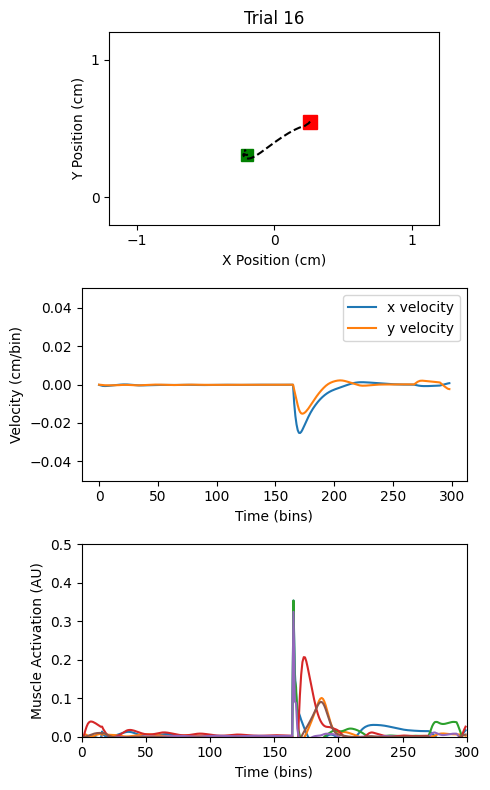

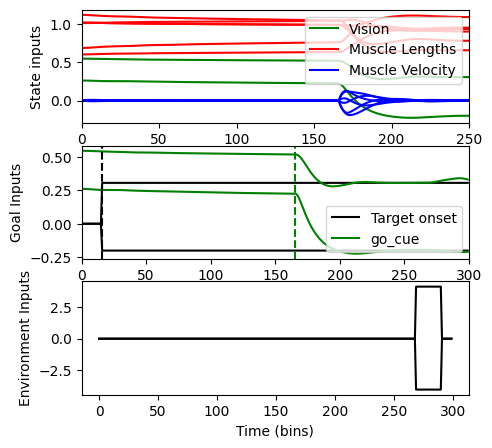

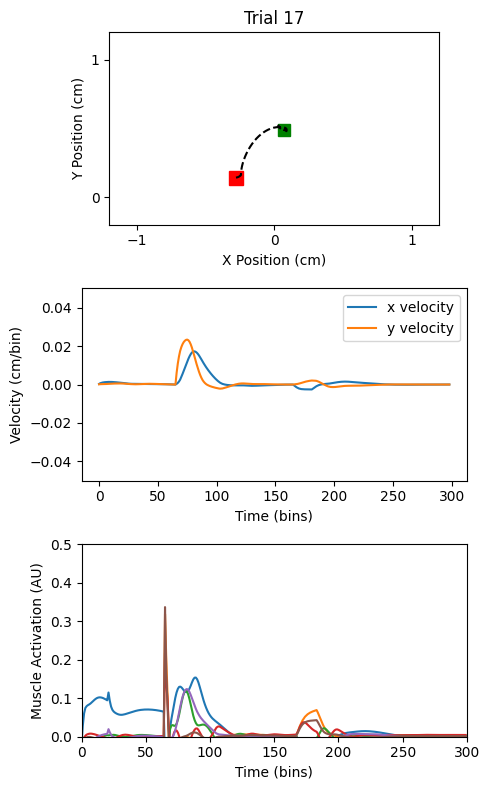

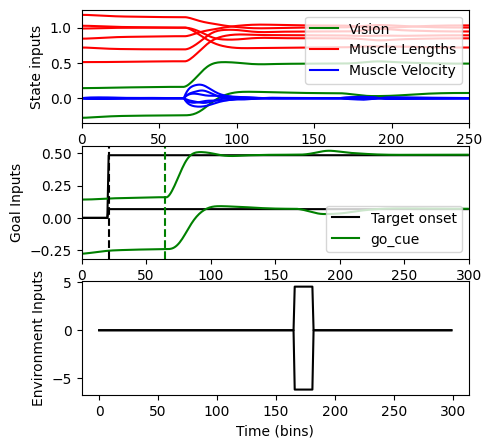

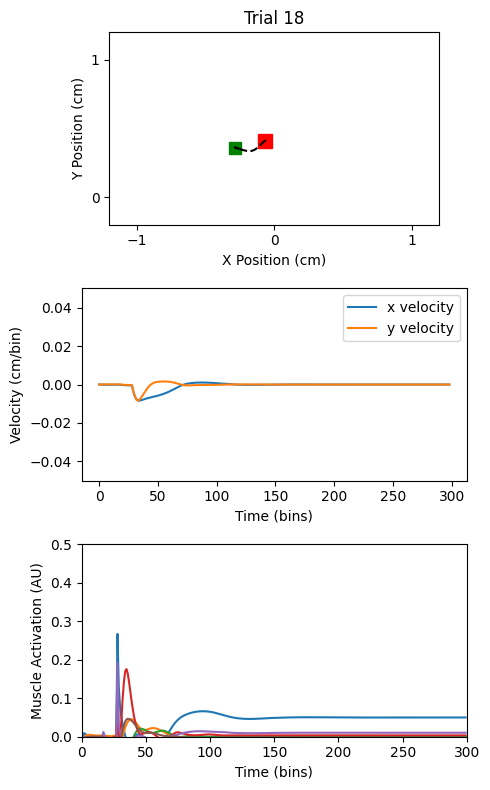

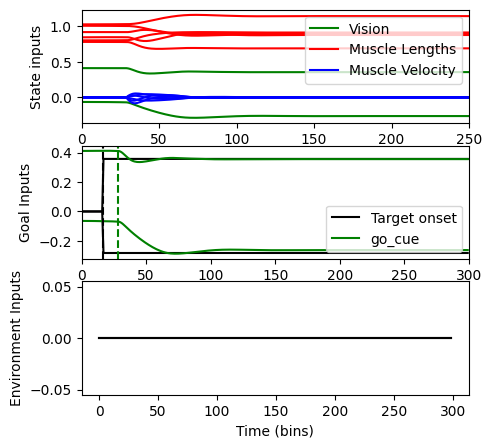

In [21]:
for x in range(16,19):
    analysis_tt_RT.plot_trial(trial_num = x)

Importantly, this task is distinct from the previous two tasks because the outputs of the model affect the subsequent inputs!

<img src="png/MotorNet Illustration-01.png" width="800"/>


Visualizing the latent dynamics of models trained on MotorNet tasks, we can see that there are complex features in the state space, but we'll leave that to you to figure out what they mean!

<img src="png/MotorNetGif.gif" width="300"/>



In summary, our three task environments were chosen to provide a feature-rich assortment of behaviors that can be used to test the accuracy of dynamical recovery of your data-trained models!

# Step 2: Neural Data Simulation
<img src="png/Step2-01.png" width="800"/>



Now that we have our RNN that is trained to perform three-bit flip-flop, we need to simulate the neural spiking activity.
For that, we are going to use the next object, called the Neural Data Simulator.



The neural data simulator is very simple; it takes in a datamodule and a trained model, and saves an .h5 file of neural firing rates to a location in your local directory where the data-trained models will be able to find it.

The process of simulating neural data has two steps:
1. Instantiate NeuralDataSimulator object with simulation parameters.
2. Pass the trained TT model, the datamodule that you want to simulate neural activity from, and some file paths to the simulate_neural_data method.

In the full code, the simulator is saved with the task-trained model so more neural activity can be simulated later if needed. Importantly, the datamodule used for simulation doesn't need to be the same datamodule used to train the model; this means allow for easy testing of generalizability of task-trained models.

Below is a schematic of the data simulation pipeline. See neural_simulator.py for information on the parameters and options for simulation.

<img src="png/SimulationDiagram.png" width="800"/>


In [22]:
from interpretability.task_modeling.simulator.neural_simulator import NeuralDataSimulator
from interpretability.task_modeling.datamodule.task_datamodule import TaskDataModule
from interpretability.task_modeling.task_env.task_env import NBitFlipFlop

# Create the task environment:
env_3bff = NBitFlipFlop(
    n = 3, 
    n_timesteps=500, 
    switch_prob=0.01, 
    noise=0.15
    )

# Create the task datamodule and generate the data:
dm_sim = TaskDataModule(env_3bff, n_samples = 1000, batch_size = 1000, seed= 4096)
dm_sim.prepare_data()
dm_sim.setup()

# Set the path to save the dataset:
dataset_path = pathlib.Path(HOME_DIR, "content", "datasets", "dt")
    
# Create the neural data simulator:
simulator = NeuralDataSimulator(
    n_neurons = 50,
    nonlin_embed=False, # IN DEVELOPMENT!
    # obs_noise = "poisson", # IN DEVELOPMENT!
)
    
wrapper = analysis_tt_3bff.wrapper
simulator.simulate_neural_data(
    task_trained_model=wrapper,
    datamodule= dm_sim,
    run_tag = "tt_3BFF_pretrained",
    subfolder="seed=4096",
    dataset_path= dataset_path,
    seed= 4096,
)

And that's it! 

We can change the number of neurons or the noise model if we want to test how violations of our assumptions can affect of inferred latent activity.

# Step 3: Data training

![Data-training](png/Step3-01.png)

Now that we have simulated "spiking" data, we can pretend that we recorded it from a brain!

One common way to estimate dynamics from neural recordings is to use a model called a Sequential Auto-Encoder (SAE).

![Data-training](png/SAE.png)

SAEs receive time-series data, and are trained with the objective of being able to reconstruct the inputs to the model as the product of a dynamical system (often with a dimensionality bottleneck).

--------------------------------------------------------------------------------------------------------------------------------------

Let's walk through how to train a model to reconstruct the simulated neural activity using the CtD Benchmark!

The models that are currently available to train on the benchmark datasets are:
- Standard SAEs (GRUs, Neural ODE, Vanilla RNNs)
- Latent Factor Analysis via Dynamical Systems (LFADS)

We are currently in the process of adding the capability for a suite of Linear Dynamical Systems models (LDS) using JAX (with help from the amazing David Zoltowski!).
- Jacobian Switching LDS
- Recurrent LDS


## The elephant in the room: Inputs?

As we have seen, inputs are an extremely important piece of the puzzle when it comes to understanding the dynamics of a system. So how will we deal with inputs for the CtD Benchmark?

We plan for our benchmark to support either supplying inputs to the model or allowing the model to use input inference when it is available (e.g., LFADS). 

For simplicity, the below models are trained with supplied ground-truth inputs.



-----------------------------------------------------------------------------------

We have provided pre-trained GRU-SAE and LFADS model trained on the 3Bit Flip-Flop task above. To train your own models, you can run the script run_data_training.py in examples/ folder!

Let's start by loading our model into a Analysis object and running fixed-point analysis on it to see what the structure looks like!


Iteration 500/10000
q = 5.19E-02 +/- 2.19E-01
dq = 2.08E-04 +/- 7.30E-04

Iteration 1000/10000
q = 1.22E-02 +/- 6.54E-02
dq = 2.63E-05 +/- 1.29E-04

Iteration 1500/10000
q = 4.96E-03 +/- 2.76E-02
dq = 7.47E-06 +/- 4.26E-05

Iteration 2000/10000
q = 2.56E-03 +/- 1.40E-02
dq = 3.02E-06 +/- 1.75E-05

Iteration 2500/10000
q = 1.51E-03 +/- 8.06E-03
dq = 1.42E-06 +/- 8.12E-06

Iteration 3000/10000
q = 9.81E-04 +/- 5.16E-03
dq = 7.78E-07 +/- 4.27E-06

Iteration 3500/10000
q = 6.75E-04 +/- 3.52E-03
dq = 4.82E-07 +/- 2.57E-06

Iteration 4000/10000
q = 4.78E-04 +/- 2.50E-03
dq = 3.18E-07 +/- 1.68E-06

Iteration 4500/10000
q = 3.47E-04 +/- 1.82E-03
dq = 2.16E-07 +/- 1.14E-06

Iteration 5000/10000
q = 2.57E-04 +/- 1.35E-03
dq = 1.49E-07 +/- 7.89E-07

Iteration 5500/10000
q = 1.94E-04 +/- 1.01E-03
dq = 1.07E-07 +/- 5.66E-07

Iteration 6000/10000
q = 1.48E-04 +/- 7.72E-04
dq = 7.94E-08 +/- 4.20E-07

Iteration 6500/10000
q = 1.13E-04 +/- 5.92E-04
dq = 5.98E-08 +/- 3.15E-07

Iteration 7000/10000
q = 

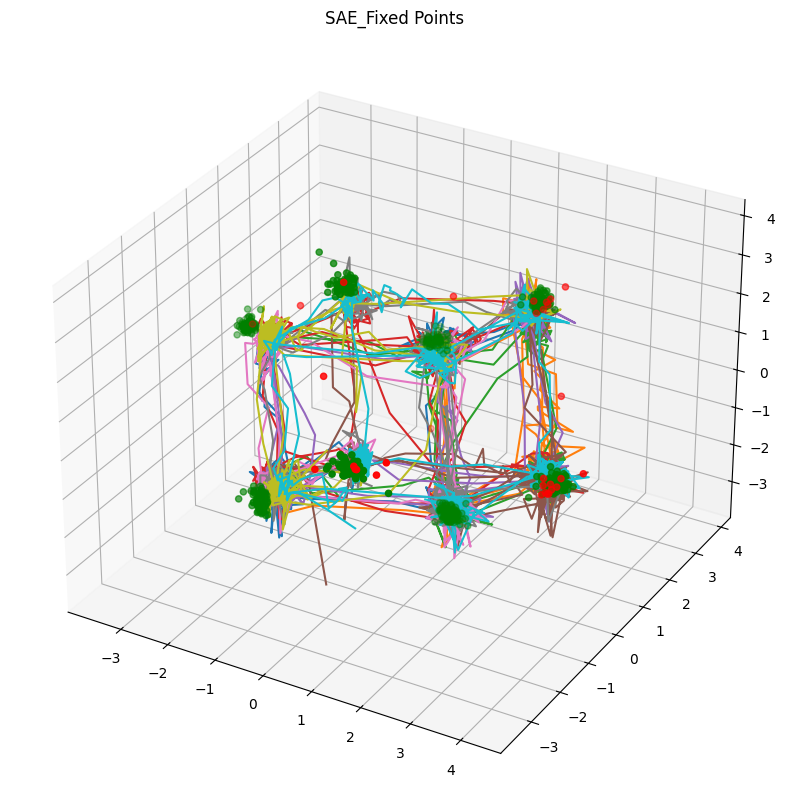

In [23]:
from interpretability.comparison.analysis.dt.dt import Analysis_DT
import dotenv
import os
import torch


dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
fpath_3bff_GRU_2_DT = ( HOME_DIR + "/pretrained_2/dt/20240301_NBFF_GRU_DT/")

analysis_dt_GRU_3bff_2 = Analysis_DT(
    run_name = "GRU_3B_1_DT",
    filepath = fpath_3bff_GRU_2_DT,)

analysis_dt_GRU_3bff_2.plot_fps(inputs = torch.zeros(3), device = "cpu") # change to CPU if available for speed

[Not great, not terrible.](https://giphy.com/clips/hamlet-chernobyl-not-great-terrible-33NFrPnlaN7lqUTM3V)

Now let's load an LFADS model trained on the same dataset to see if LFADS can get more accurate latent dynamics than the GRU.

Unfortunately, Colab doesn't have the RAM to load LFADS, so I'm also including the plots here for reference

In [24]:
# import torch
# from interpretability.comparison.analysis.dt.dt import Analysis_DT
# fpath_3bff_LFADS_2_DT =( HOME_DIR + "pretrained_2/dt/20240302_NBFF_LFADS_DT/")

# analysis_dt_LFADS_3bff_2 = Analysis_DT(
#     run_name = "LFADS_3B_1_DT",
#     filepath = fpath_3bff_LFADS_2_DT,
#     model_type = "LFADS"
#     )

# analysis_dt_LFADS_3bff_2.plot_trial(num_trials=10)

# analysis_dt_LFADS_3bff_2.plot_fps( # For those with more RAM than Colab!
#     inputs = torch.zeros(3),
#     n_inits=512,
# )


Colab unfortunately doesn't have enough RAM to run the full heavy duty model for Fixed-Point finding, but I'm putting the resulting plot here for your reference; feel free to run this on a more powerful machine if you want to mess around with the parameters!

<img src="png/lfads_fps.png" width="800"/>

Qualitatively, LFADS looks like it's doing great at recovering the fixed points!

Now that we have walked through the data-training process, let's see some of the metrics that we are using to quantify the performance on latent recovery!

# Step 4: Comparing task-trained and data-trained networks

<img src="png/Step4-01.png" width="800"/>


Now that we've walked through the pipeline, let's get down to what we came here to do! 

**How can we compare the performance of our models in a quantitative way?**

I'm going to give toy examples to demonstrate the three metrics that we have implemented for quantitatively comparing our dynamics models:
1. Rate $R^2$
2. State $R^2$
2. Dynamical Similarity Analysis

To do this, let's use the NBFF task described above!

## Metric 1: Rate $R^2$


The first metric that is important to know is: Does our model actually fit the data well?

For that, we turn to Rate $R^2$. Rate $R^2$ is simply the goodness of fit between the inferred firing rates and the ground-truth activity of the task-trained network.

Let's load up a couple of networks and see how well they fit the data.

In [25]:
from interpretability.comparison.analysis.tt.tt import Analysis_TT
from interpretability.comparison.analysis.dt.dt import Analysis_DT
fpath_3bff_GRU_2 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=2/"
analysis_tt_GRU_3bff_2 = Analysis_TT(
    run_name = "GRU_3B_2", 
    filepath = fpath_3bff_GRU_2,
)

fpath_3bff_GRU_2_DT = (HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=2/20240301_NBFF_GRU_DT/")
analysis_dt_GRU_3bff_2 = Analysis_DT(
    run_name = "GRU_3B_1_DT",
    filepath = fpath_3bff_GRU_2_DT,
    )

fpath_3bff_Vanilla_2_DT = (HOME_DIR + "pretrained_2/dt/20240303_NBFF_VanillaRNN_DT/")
analysis_dt_Vanilla_3bff_2 = Analysis_DT(
    run_name = "Vanilla_3B_1_DT",
    filepath = fpath_3bff_Vanilla_2_DT,
    )

    

We have loaded three models into our Comparison object. The comparison object has built-in methods for quantified comparisons between models that have been loaded into it.

The three models in this Comparison are:
1. A Task-Trained GRU performing 3-bit Flip Flop
2. A Data-Trained GRU that was trained using data from (1).
3. A Data-Trained Vanilla RNN that was trained using data from (1).

Now we're going to test which model reconstructs the rates best!

In [26]:
from interpretability.comparison.comparison import Comparison
comparison_R2 = Comparison()
comparison_R2.load_analysis(analysis_tt_GRU_3bff_2, reference_analysis=True)
comparison_R2.load_analysis(analysis_dt_GRU_3bff_2)
comparison_R2.load_analysis(analysis_dt_Vanilla_3bff_2)

When we compute Rate $R^2$, we get an $R^2$ value for every simulated neuron. For simplicity, we summarize the reconstruction performance of each model by taking the mean value across neurons.

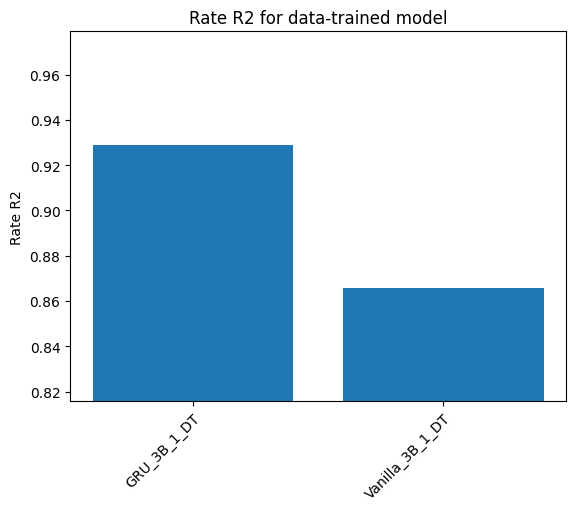

In [27]:
comparison_R2.compare_rate_r2()

Unsurprisingly, the GRU model is better able to reconstruct the firing rates of the task-trained model than the Vanilla RNN.

However: recent work from the Pandarinath lab has shown that models have an incentive to "invent" latent features if those features are helpful in reconstructing the neural activity. Therefore, optimizing for reconstruction performance can actually impose a perverse incentive for *less accurate* neural dynamics!

## Metric 2: State $R^2$

To address this concern, we introduce our second metric, called State $R^2$. State $R^2$ measures the extent to which the model reflects *only* the latent activity that is actually in the ground-truth system.

<img src="png/StateR2-01.png" width="600"/>

To provide some intuition for this metric, we're going to consider a very simple case. There are two shapes in the figure above, a ring and a wave. If the true underlying dynamics resemble the ring but our model-inferred dynamics resemble the wave, our model would be able to predict the flat ring on the right with high accuracy, but the flat ring cannot predict the wave.


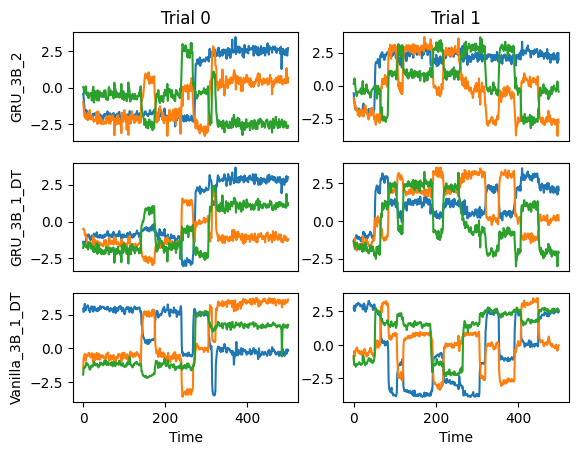

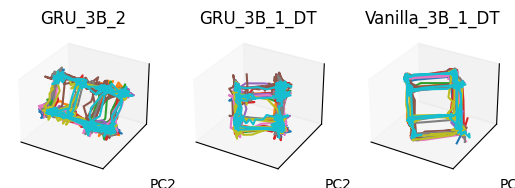

In [28]:

comparison_R2.plot_trials(num_trials=2)
comparison_R2.plot_trials_3d(num_trials=10)


If the datasets that we are interested in comparing have a 1:1 mapping between samples (i.e., they were seeing the same trials), then we can also provide one of the models as a "reference analysis", which will tell the plotting functions to linearly align the latent activity in the optimal way to predict the reference dataset. The first plot (without alignment) could potentially make it seem as though there are differences in the latent activity between the task-trained and data-trained models. The goodness-of-fit of this optimal affine transformation is defined as the State $R^2$.

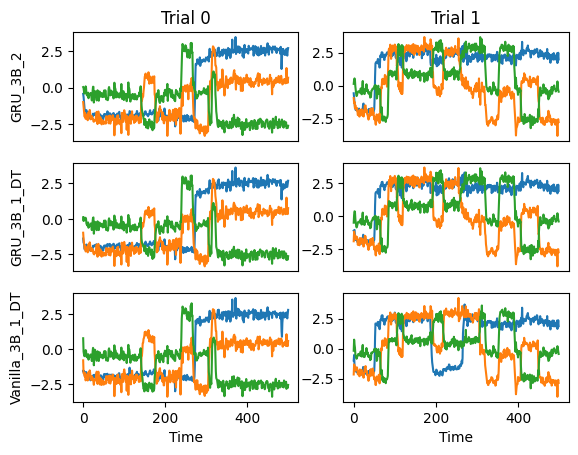

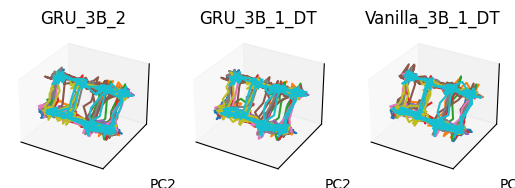

In [29]:
comparison_R2.plot_trials_reference(num_trials=2)
comparison_R2.plot_trials_3d_reference(num_trials=10)

Importantly, goodness-of-fit is calculated for each dimension independently and averaged, so dimensionality affects the estimated State $R^2$.

Try changing the num_pcs and see how this metric is affected!

array([[1.        , 0.9903987 , 0.96151987],
       [0.99018553, 1.        , 0.96957408],
       [0.96140643, 0.96956494, 1.        ]])

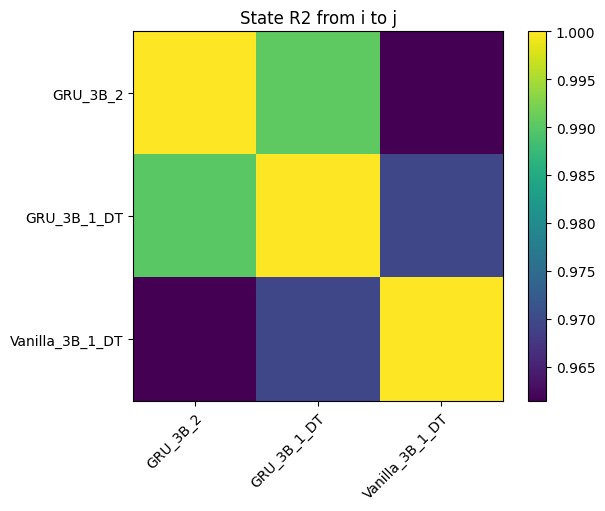

In [30]:
comparison_R2.compare_state_r2(num_pcs=3)

Looks like our GRU network is strictly better than our Vanilla RNN! Both the state and rate $R^2$ are higher, meaning that the GRU can reconstruct the neural activity better and doesn't seem to have invented latent features to do so!

## Metric 3: Dynamical Similarity Analysis:

Let's look at another toy problem of differentiating different computations being performed by RNNs. For this problem, I've chosen to train GRU models to perform 3, 4, and 5 bit versions of our N-bit Flip-Flop task. This presents an interesting challenge for methods of distinguishing dynamical systems, because the dynamics of 4 and 5 bit flip flop models actually contain within them (more than one!) three bit flip flop task!

Mitchell Ostrow is here to give a tutorial of his method, Dynamical Similarity Analysis!

---------------------------------------------------------------------------------

Now to see how it performs in action! 


The code below loads a few pre-trained models into analysis objects:
Specifically, I've provided two randomly initializations of training data and weights for GRU models trained to perform 3BFF, 4BFF, and 5BFF.

I've also supplied a Data-Trained model trained on the simulated spiking activity from one of the models in the task so that we can see if the task-trained network resembles the data-trained network in this test case.

In [31]:
from interpretability.comparison.analysis.tt.tt import Analysis_TT
from interpretability.comparison.analysis.dt.dt import Analysis_DT

fpath_3bff_GRU_1 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=0/"
analysis_tt_GRU_3bff_1 = Analysis_TT(
    run_name = "GRU_3B_1", 
    filepath = fpath_3bff_GRU_1,)

fpath_3bff_GRU_1_dt = HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=2/20240301_NBFF_GRU_DT/"
analysis_dt_GRU_3bff_1 = Analysis_DT(
    run_name = "GRU_3B_1_DT", 
    filepath = fpath_3bff_GRU_1_dt,)

fpath_3bff_GRU_2 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_3BFF_GRU_Tutorial/n=3 weight_decay=1e-08 max_epochs=1500 seed=2/"
analysis_tt_GRU_3bff_2 = Analysis_TT(
    run_name = "GRU_3B_2", 
    filepath = fpath_3bff_GRU_2,)

fpath_4bff_GRU_1 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_4BFF_GRU_Tutorial/n=4 weight_decay=1e-08 max_epochs=1500 seed=0/"
analysis_tt_GRU_4bff_1 = Analysis_TT(
    run_name = "GRU_4B_1", 
    filepath = fpath_4bff_GRU_1,)

fpath_4bff_GRU_2 = HOME_DIR + "pretrained_2/tt/NBFF/20240229_4BFF_GRU_Tutorial/n=4 weight_decay=1e-08 max_epochs=1500 seed=2/"
analysis_tt_GRU_4bff_2 = Analysis_TT(
    run_name = "GRU_4B_2", 
    filepath = fpath_4bff_GRU_2,)   

fpath_5bff_GRU_1 = HOME_DIR + "pretrained_2/tt/NBFF/20240301_5BFF_GRU_Tutorial/n=5 weight_decay=1e-08 max_epochs=1500 seed=0/"
analysis_tt_GRU_5bff_1 = Analysis_TT(
    run_name = "GRU_5B_1",
    filepath = fpath_5bff_GRU_1,)

fpath_5bff_GRU_2 = HOME_DIR + "pretrained_2/tt/NBFF/20240301_5BFF_GRU_Tutorial/n=5 weight_decay=1e-08 max_epochs=1500 seed=2/"
analysis_tt_GRU_5bff_2 = Analysis_TT(
    run_name = "GRU_5B_2",
    filepath = fpath_5bff_GRU_2,)



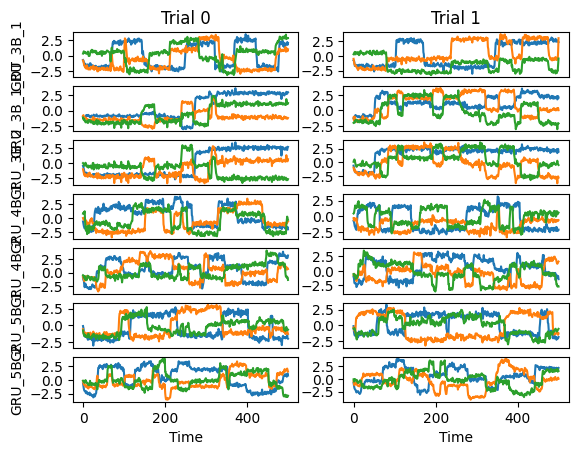

In [32]:
from interpretability.comparison.comparison import Comparison
comparison_DSA = Comparison()
comparison_DSA.load_analysis(analysis_tt_GRU_3bff_1)
comparison_DSA.load_analysis(analysis_dt_GRU_3bff_1)
comparison_DSA.load_analysis(analysis_tt_GRU_3bff_2)
comparison_DSA.load_analysis(analysis_tt_GRU_4bff_1)
comparison_DSA.load_analysis(analysis_tt_GRU_4bff_2)
comparison_DSA.load_analysis(analysis_tt_GRU_5bff_1)
comparison_DSA.load_analysis(analysis_tt_GRU_5bff_2)

comparison_DSA.plot_trials(num_trials=2)


Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HA

array([[0.        , 0.05455676, 0.05174516, 0.19162987, 0.26163268,
        0.38896728, 0.3915334 ],
       [0.05455676, 0.        , 0.07339525, 0.22347218, 0.29449716,
        0.42253137, 0.42450413],
       [0.05174516, 0.07339525, 0.        , 0.16912352, 0.24002333,
        0.36725301, 0.36819109],
       [0.19162987, 0.22347218, 0.16912352, 0.        , 0.10685838,
        0.21960343, 0.2214213 ],
       [0.26163268, 0.29449716, 0.24002333, 0.10685838, 0.        ,
        0.15227942, 0.15534358],
       [0.38896728, 0.42253137, 0.36725301, 0.21960343, 0.15227942,
        0.        , 0.0742358 ],
       [0.3915334 , 0.42450413, 0.36819109, 0.2214213 , 0.15534358,
        0.0742358 , 0.        ]])

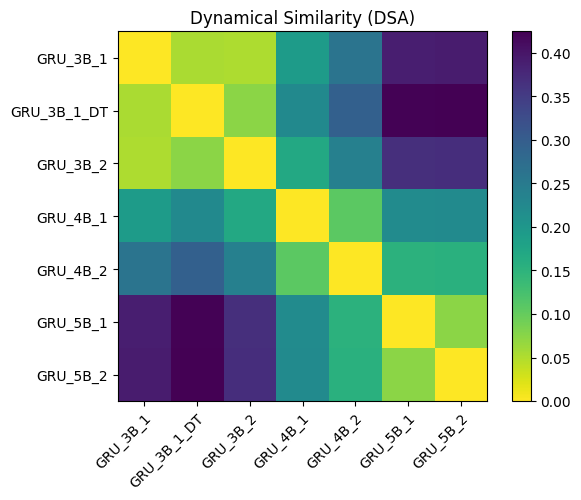

In [33]:
comparison_DSA.compare_dynamics_DSA(n_delays=50, rank = 200, percent_data=0.1, device = "cuda" ) # Set to "cpu" on Colab!

We can see that not only does DSA say that the GRU network trained on the simulated 3BFF data resembles the true underlying 3BFF data, we can also see that there is an orderly gradient of similarities as the systems become more complicated!

DSA seems to be able to capture similar dynamical systems, even when we don't have a point-to-point matching between systems!

# Conclusion + Next Steps:

Hope everyone found the tutorial informative (and that the Colab notebook worked :D ) ! We hope that you download the Benchmark codebase and put it to good use validating and comparing your data-trained models!

We plan to continue developing the CtD Benchmark to make it more useful to researchers, so if you are interested in adding features, reach out and let me know!

In particular:
- Better documentation + streamlined interface 
- New Metrics: CCA + variants
- New models: Fuller range of Linear Dynamical Systems models!
- New Task Environments: 
- A "Challenge" dataset for which we provide simulated neural activity without a ground truth, and challenge researchers to tell us what is happening!


# Thanks!

This couldn't possibly have come together without a whole host of help from a lot of people!

My mentor/co-organizer Chethan Pandarinath

The speakers:
- Srdjan Ostojic
- Chethan Pandarinath
- Tatiana Engel
- David Sussillo
- Kanaka Rajan
- Mitchell Ostrow

The CtD Benchmark Advisory Team:
- Chethan Pandarinath
- David Sussillo
- Srdjan Ostojic
- Scott Linderman

For help building features into the Benchmark:
- Laura Driscoll
- Oli Codol
- Jonathan Michaels
- David Zoltowski
- Sophie Liebkind
- Felix Pei
- Jonathan McCart

For help developing the tutorial notebook:
- Clay Washington
- Domenick Mifsud


Hope everyone has a safe trip home, and I'll see you next year!

